# Spatial Coalescence Model
Rowan Hart

In [5]:
# Import Software
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import pyslim
import argparse
import pickle
import pysam
import subprocess
import os
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import functools
import tskit
import networkx as nx

np.random.seed(23)

In [6]:
# Lukes Functions

def get_nodes_above_sample(ts, G, sample_id):
    nodes_above_sample = []
    current_node = sample_id
    while True:
        predecessors = list(G.predecessors(current_node))
        if not predecessors:
            break
        parent_node = predecessors[0]
        nodes_above_sample.append((sample_id, parent_node))
        current_node = parent_node
    return nodes_above_sample

def build_graph(ts):
    G = nx.DiGraph()
    for tree in tqdm(ts.trees(), desc="Building graph"):
        for u in tree.nodes():
            G.add_node(u)
            for v in tree.children(u):
                G.add_edge(u, v)
    return G

# Osmand Functions (Not Quite Sure what it does yet)

def get_shared_times(ts):
    'get shared evolutionary times between all samples in treesequence using general_stat'

    k = ts.num_samples
    W = np.identity(k) # each node, i in [0,1,...,k] given row vector of weights with 1 in column i and 0's elsewhere 
    def f(x): return (x.reshape(-1,1) * x).flatten() # matrix with 1's where branch above a node with value x contributes to shared time between samples 
    
    return ts.general_stat(
               W, f, k**2, mode='branch', windows='trees', polarised=True, strict=False
           ).reshape(ts.num_trees, k, k)

In [25]:
# PySLiM
slim_ts = pyslim.tskit.load("osmand_200_no_rec_Anc.trees")
print(f"The tree sequence has {slim_ts.num_trees} trees\n"
      f"on a genome of length {slim_ts.sequence_length},\n"
      f"{slim_ts.num_individuals} individuals, {slim_ts.num_samples} 'sample' genomes,\n"
      f"and {slim_ts.num_mutations} mutations.")
slim_ts

The tree sequence has 1 trees
on a genome of length 100000000.0,
211833 individuals, 8600 'sample' genomes,
and 0 mutations.


In [26]:
# Get Locations of all Samples
locations = []
for i in np.arange(slim_ts.num_nodes):
    ind = slim_ts.node(i).individual #individual each sample belongs to
    loc = slim_ts.individual_locations[ind] #location of each individual
    locations.append(loc[:2]) #x,y location of each sample
locations = np.array(locations)

In [43]:
a = np.where(((10 < locations[:,0]) & (locations[:,0] < 40)))

In [44]:
a

(array([     4,      5,      6, ..., 221852, 221854, 221855]),)

In [37]:
locations[0]

array([45.8717327 , 20.91526835])

In [65]:
# Function that Returns Nodes within a Boundry
def within_bound(dmin, dmax, locations, treeseq):
    a = np.where(((dmin < locations[:,0]) & (locations[:,0] < dmax)))
    b = np.where(((dmin < locations[:,1]) & (locations[:,1] < dmax)))
    c = pyslim.individuals_alive_at(treeseq, 0)
    return np.intersect1d(np.intersect1d(a,b), c)

In [67]:
a = within_bound(15, 35, locations, slim_ts)

In [63]:
slim_ts.individual(184314)

Individual(id=184314, flags=262144, location=array([35.92029594,  9.07086636,  0.        ]), parents=array([183458, 183459], dtype=int32), nodes=array([41838], dtype=int32), metadata={'pedigree_id': 88198701, 'pedigree_p1': 88192611, 'pedigree_p2': 88192612, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0})

In [58]:
slim_ts.samples()

array([   0,    1,    2, ..., 8597, 8598, 8599], dtype=int32)

In [9]:
individual_times = slim_ts.individuals_time
query = [0, 1000, 5000, 15000, 19999]
for t in query:
    print(f"There are {np.sum(individual_times == t)} individuals from time {t}.")

There are 4216 individuals from time 0.
There are 24 individuals from time 1000.
There are 7 individuals from time 5000.
There are 5 individuals from time 15000.
There are 3 individuals from time 19999.


In [10]:
slim_ts.max_root_time

19999.0

In [11]:
# Build Graphs
G = build_graph(slim_ts)

Building graph: 100%|█████████████████████████| 119/119 [01:19<00:00,  1.49it/s]


In [23]:
slim_ts.node(11060)

Node(id=11060, flags=0, time=1.0, population=1, individual=218186, metadata={'slim_id': 176600010, 'is_null': False, 'genome_type': 0})

In [65]:
# Get Matrix of ancestors for n individuals
def get_anc_array(tree_seq, G, n):
    coal_matx = np.zeros((n, int(tree_seq.max_root_time)))
    for i in np.arange(n):
        data = get_nodes_above_sample(tree_seq, G, i)
        coal_matx[i] = [t[1] for t in data]
    return coal_matx

In [172]:
# Calculate Coalescence times
def coal_times(coal_matx):
    ct = np.zeros((np.shape(coal_matx)[0],np.shape(coal_matx)[0]))
    for i in np.arange(np.shape(coal_matx)[0]):
        for j in np.arange(np.shape(coal_matx)[0]):
            tf = np.where(np.equal(coal_matx[i], coal_matx[j]) == True)[0]
            if tf.size == 0:
                ct[i,j] = 0
            else:
                ct[i,j] = tf[0] + 1
    return ct

In [168]:
at = get_anc_array(slim_ts, G, 1000)

In [173]:
ct = coal_times(at)
ct[10]

array([6.8500e+02, 6.8500e+02, 6.8500e+02, 6.8500e+02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.0000e+00, 5.0000e+00, 1.0000e+00, 0.0000e+00, 1.3902e+04,
       1.3902e+04, 1.3902e+04, 1.3902e+04, 1.3902e+04, 1.3902e+04,
       1.3902e+04, 1.3902e+04, 1.3902e+04, 1.3902e+04, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3902e+04,
       1.3902e+04, 1.3902e+04, 1.3902e+04, 1.3902e+04, 1.3902e+04,
       1.3902e+04, 1.3902e+04, 5.0480e+03, 1.3902e+04, 5.0480e+03,
       1.3902e+04, 0.0000e+00, 1.3902e+04, 5.0480e+03, 5.0480e+03,
       0.0000e+00, 5.0480e+03, 2.5800e+02, 2.5800e+02, 3.1000e+01,
       2.5800e+02, 0.0000e+00, 0.0000e+00, 1.7200e+02, 1.3902e+04,
       1.7200e+02, 1.3902e+04, 1.7200e+02, 1.3902e+04, 0.0000e

In [44]:
slim_ts.nodes_individual[777]

388

In [41]:
slim_ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,1,0,0,"{'slim_id': 176573660, 'is_null': Fal..."
1,1,1,0,0,"{'slim_id': 176573661, 'is_null': Fal..."
2,1,1,1,0,"{'slim_id': 176573662, 'is_null': Fal..."
3,1,1,1,0,"{'slim_id': 176573663, 'is_null': Fal..."
4,1,1,2,0,"{'slim_id': 176573664, 'is_null': Fal..."
5,1,1,2,0,"{'slim_id': 176573665, 'is_null': Fal..."
6,1,1,3,0,"{'slim_id': 176573666, 'is_null': Fal..."
7,1,1,3,0,"{'slim_id': 176573667, 'is_null': Fal..."
8,1,1,4,0,"{'slim_id': 176573668, 'is_null': Fal..."
9,1,1,4,0,"{'slim_id': 176573669, 'is_null': Fal..."


In [77]:
slim_ts.num_nodes

221858

In [79]:
np.shape(locations)

(221858, 2)

In [108]:
def anc_walk(anc_matx, locations, id):
    x = [locations[int(i),0] for i in anc_matx[id]]
    y = [locations[int(i),1] for i in anc_matx[id]]
    return x,y

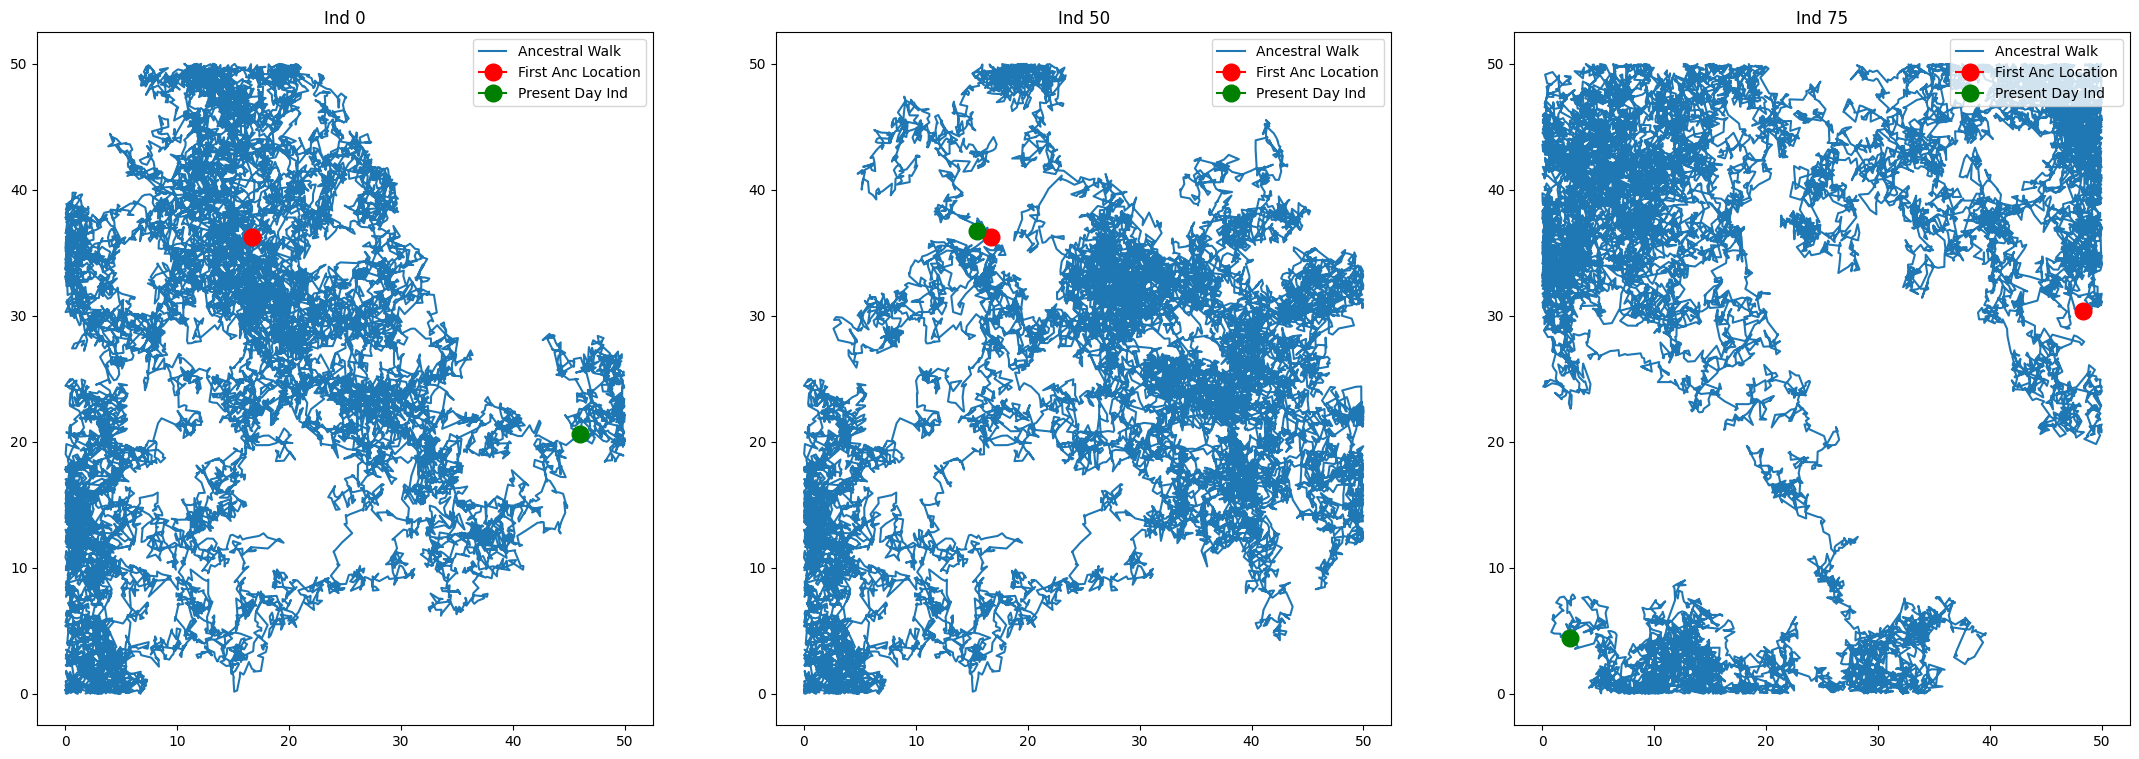

In [149]:
locs1 = anc_walk(at, locations, 0)
locs2 = anc_walk(at, locations, 50)
locs3 = anc_walk(at, locations, 75)

fig, ax1 = plt.subplots(1, 3)
fig.set_size_inches(27, 9)
ax1[0].set_title("Ind 0")
ax1[0].plot(locs1[0], locs1[1])
ax1[0].plot(locs1[0][-1], locs1[1][-1], color = 'Red', marker='o', markersize=12)
ax1[0].plot(locs1[0][0], locs1[1][0], color = 'Green', marker='o', markersize=12)
ax1[0].legend(['Ancestral Walk','First Anc Location','Present Day Ind'], loc="upper right")
ax1[1].set_title("Ind 50")
ax1[1].plot(locs2[0], locs2[1]);
ax1[1].plot(locs2[0][-1], locs2[1][-1], color = 'Red', marker='o', markersize=12)
ax1[1].plot(locs2[0][0], locs2[1][0], color = 'Green', marker='o', markersize=12)
ax1[1].legend(['Ancestral Walk','First Anc Location','Present Day Ind'], loc="upper right")
ax1[2].set_title("Ind 75")
ax1[2].plot(locs3[0], locs3[1]);
ax1[2].plot(locs3[0][-1], locs3[1][-1], color = 'Red', marker='o', markersize=12)
ax1[2].plot(locs3[0][0], locs3[1][0], color = 'Green', marker='o', markersize=12)
ax1[2].legend(['Ancestral Walk','First Anc Location','Present Day Ind'], loc="upper right")

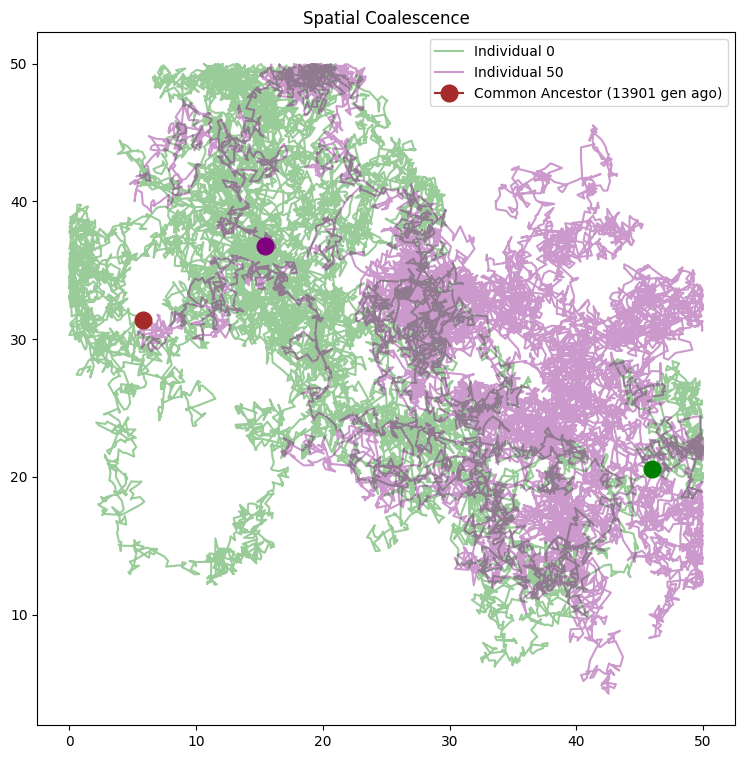

In [163]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(9, 9)
ax1.set_title("Spatial Coalescence")
ax1.plot(locs1[0][:int(ct[0,50])], locs1[1][:int(ct[0,50])], color = 'Green', alpha = 0.4)
ax1.plot(locs2[0][:int(ct[0,50])], locs2[1][:int(ct[0,50])], color = 'Purple', alpha = 0.4)
ax1.plot(locs2[0][int(ct[0,50])], locs2[1][int(ct[0,50])], color = 'Brown', marker='o', markersize=12)
ax1.plot(locs1[0][0], locs1[1][0], color = 'Green', marker='o', markersize=12)
ax1.plot(locs2[0][0], locs2[1][0], color = 'Purple', marker='o', markersize=12)
ax1.legend(['Individual 0','Individual 50','Common Ancestor (13901 gen ago)'], loc="upper right")

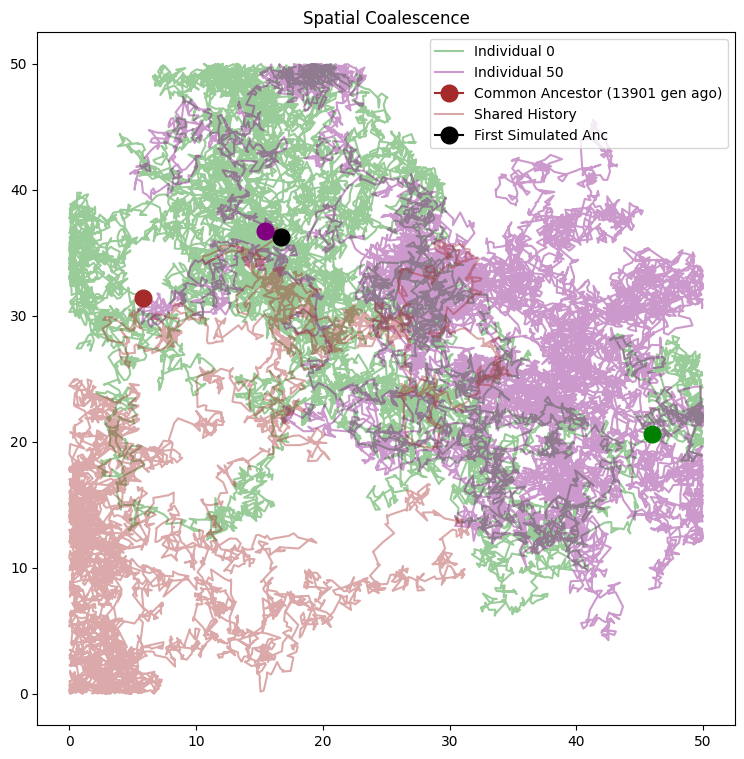

In [167]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(9, 9)
ax1.set_title("Spatial Coalescence")
ax1.plot(locs1[0][:int(ct[0,50])], locs1[1][:int(ct[0,50])], color = 'Green', alpha = 0.4)
ax1.plot(locs2[0][:int(ct[0,50])], locs2[1][:int(ct[0,50])], color = 'Purple', alpha = 0.4)
ax1.plot(locs2[0][int(ct[0,50])], locs2[1][int(ct[0,50])], color = 'Brown', marker='o', markersize=12)
ax1.plot(locs2[0][int(ct[0,50]):], locs2[1][int(ct[0,50]):], color = 'Brown', alpha = 0.4)
ax1.plot(locs1[0][-1], locs1[1][-1], color = 'Black', marker='o', markersize=12)
ax1.plot(locs1[0][0], locs1[1][0], color = 'Green', marker='o', markersize=12)
ax1.plot(locs2[0][0], locs2[1][0], color = 'Purple', marker='o', markersize=12)
ax1.legend(['Individual 0','Individual 50','Common Ancestor (13901 gen ago)', 'Shared History', 'First Simulated Anc'], loc="upper right")

In [216]:
# Get Distributions of Spatial Distances
def hgb(anc_matx, locations, gen, bins):
    x1 = np.array([locations[int(i),0] for i in anc_matx[:,0]])
    y1 = np.array([locations[int(i),1] for i in anc_matx[:,0]])
    x2 = np.array([locations[int(i),0] for i in anc_matx[:,gen]])
    y2 = np.array([locations[int(i),1] for i in anc_matx[:,gen]])
    xd = x1-x2
    yd = y1-y2
    fig, axs = plt.subplots(1,1)
    fig.suptitle("Distance From Ancestor " + str(gen) + " generations ago")
    axs.hist(xd, bins, color = 'green', alpha=.4)
    axs.hist(yd, bins, color = 'purple', alpha=.4)
    axs.set_xlabel("Distance to Anc")
    axs.set_ylabel("Frequency")
    axs.set_ylim(0,60)
    axs.set_xlim(-50,50)
    axs.grid(False)
    axs.legend(['X axis','Y axis'], loc="upper right")
    return

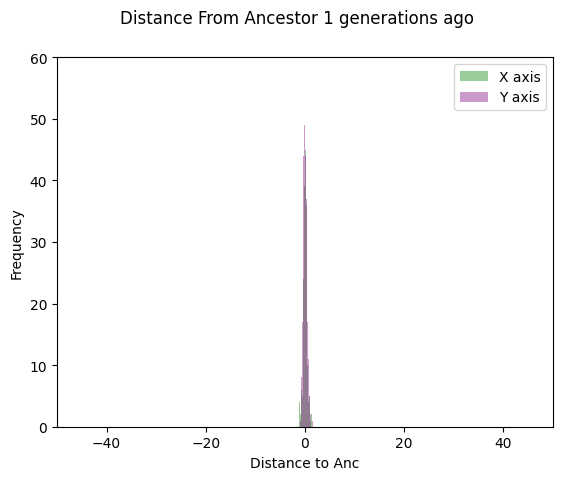

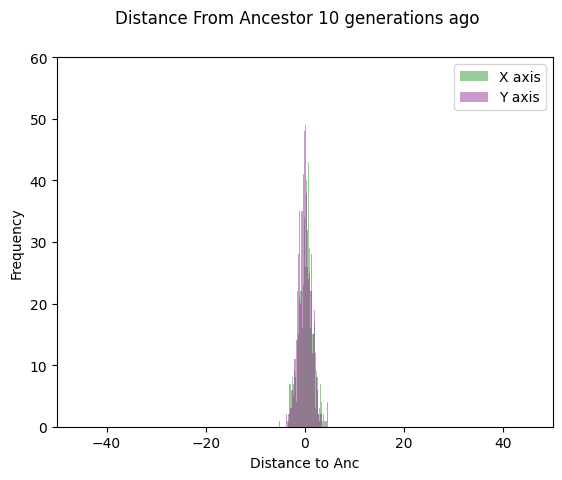

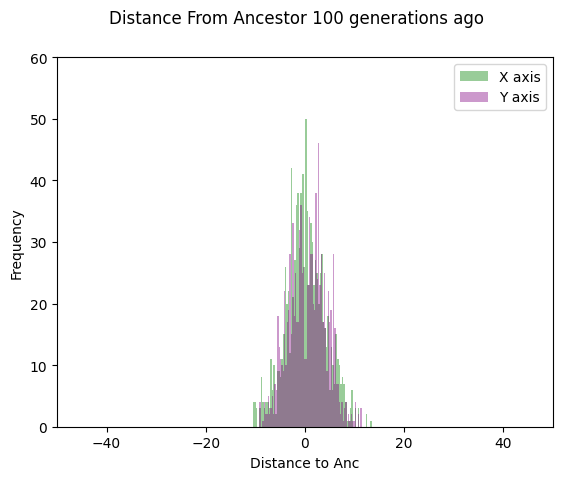

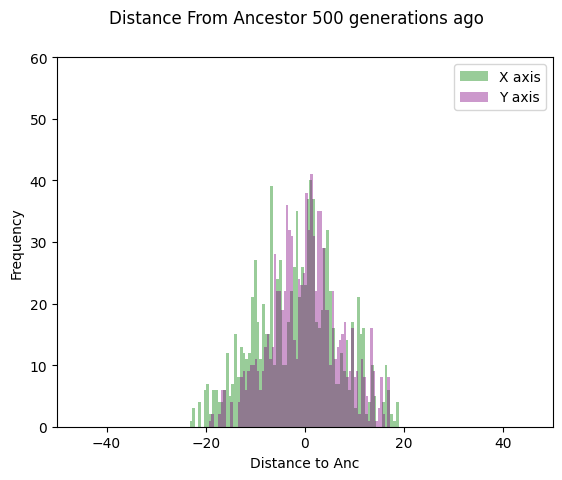

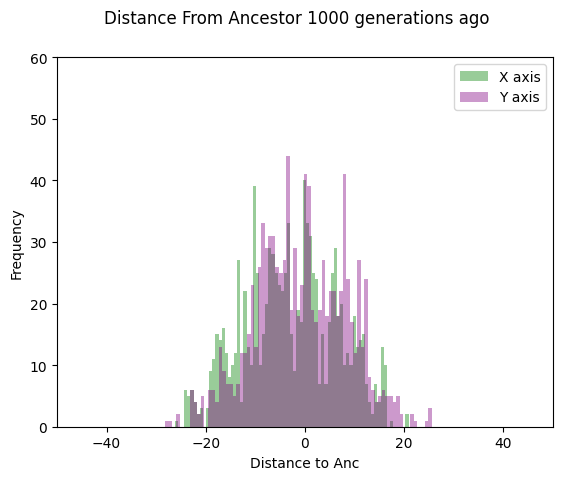

In [225]:
hgb(at, locations, 1, 75)
hgb(at, locations, 10, 75)
hgb(at, locations, 100, 75)
hgb(at, locations, 500, 75)
hgb(at, locations, 1000, 75)

In [230]:
x = [locations[int(i),0] for i in anc_matx[id]]
y = [locations[int(i),1] for i in anc_matx[id]]

[array([46.02407314, 20.40307148]),
 array([45.64008041, 20.38001085]),
 array([46.04739753, 20.4487801 ]),
 array([45.76555165, 20.49989304]),
 array([44.81900673, 20.64186739]),
 array([44.52699791, 20.80233667]),
 array([44.72994693, 20.72628596]),
 array([44.84063925, 21.92773244]),
 array([45.95729355, 22.24213791]),
 array([45.90014207, 21.65263825]),
 array([46.33218257, 21.63698228]),
 array([46.46251462, 21.82120961]),
 array([46.76815914, 21.70391093]),
 array([46.63551439, 21.90564649]),
 array([46.85273519, 22.21876655]),
 array([47.79691921, 22.47088333]),
 array([49.02638005, 21.65725047]),
 array([48.81631012, 21.63868049]),
 array([48.73108477, 21.55787052]),
 array([48.46635573, 22.32798427]),
 array([48.68843049, 22.22896192]),
 array([48.75023281, 22.21088765]),
 array([48.91911044, 22.42355904]),
 array([49.19624736, 22.50849872]),
 array([49.07814617, 23.01701733]),
 array([49.55782857, 22.35863526]),
 array([49.63096539, 21.93132858]),
 array([49.72790566, 22.0169

In [286]:
# Function that compares two strains
def dist_otime(node1, node2, anc_matx, locations):
    x1 = np.array([locations[int(i),0] for i in anc_matx[node1]])
    y1 = np.array([locations[int(i),1] for i in anc_matx[node1]])
    x2 = np.array([locations[int(i),0] for i in anc_matx[node2]])
    y2 = np.array([locations[int(i),1] for i in anc_matx[node2]])
    return np.sqrt((x1 - x2)**2 + (y1-y2)**2)

def graph_dist(node1, node2, anc_matx, locations, coal, tree_seq):
    dist = dist_otime(node1, node2, anc_matx, locations)
    x = np.linspace(0,int(tree_seq.max_root_time), int(tree_seq.max_root_time))
    fig, axs = plt.subplots(1,1)
    fig.suptitle("Distance Between Two Lineages Over Time")
    axs.plot(x, dist, color = 'Blue', alpha=.5)
    axs.axhline(y=dist[0], color ='Red', linestyle = '--')
    axs.set_xlabel("Generations in the past (Genetic Ancestors)")
    axs.set_ylabel("Distance Between Lineages $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$")
    axs.grid(False)
    axs.legend(['Distance between Lineages','Present Day Distance'], loc="upper right")
    return

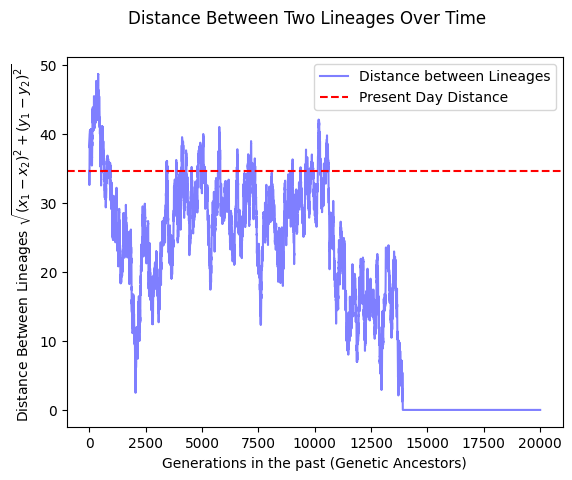

In [287]:
graph_dist(0, 50, at, locations, ct, slim_ts)

In [296]:
def data4ct(ct, at, locations, goc):
    nodes = np.where(ct == goc)
    data = np.zeros((np.shape(nodes)[1], 500))
    for i in np.arange(np.shape(nodes)[1]):
        data[i] = dist_otime(nodes[0][i], nodes[1][i], at, locations)[:500]
    return np.unique(data, axis=0)

In [303]:
data = data4ct(ct, at, locations, 100)

In [314]:
data.mean(axis=0)[0]

7.542359801681364

In [337]:
def graph_d4ct(ct, at, locations, goc):
    data = data4ct(ct, at, locations, goc)
    x = np.linspace(0, 499, 500)
    fig, axs = plt.subplots(1,1)
    axs.set_title("All Lineages that Coalecse after " + str(goc - 1) + " generations")
    axs.axhline(y=data.mean(axis=0)[0], color ='Red', linestyle = '--')
    for i in np.arange(np.shape(data)[0]):
        axs.plot(x, data[i], alpha=.5)
    axs.set_xlabel("Generations in the past (Genetic Ancestors)")
    axs.set_ylabel("Distance Between Lineages $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$")
    axs.grid(False)
    axs.legend(["Average Starting Distance"])
    axs.set_xlim(0, goc+5)

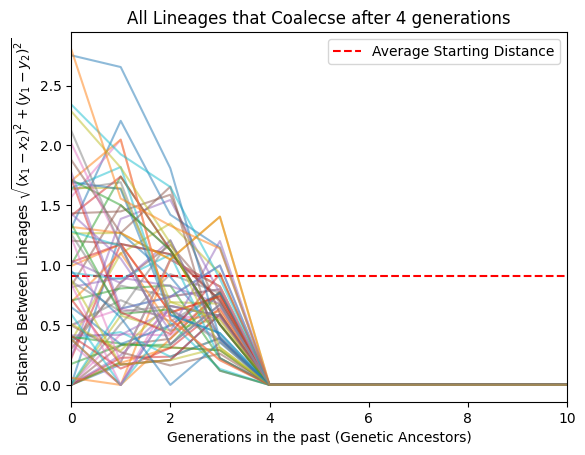

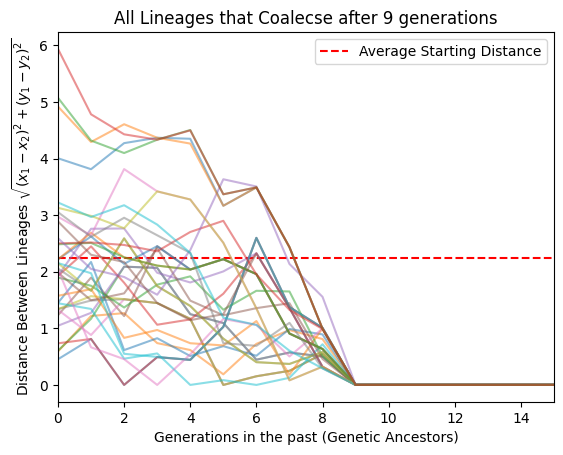

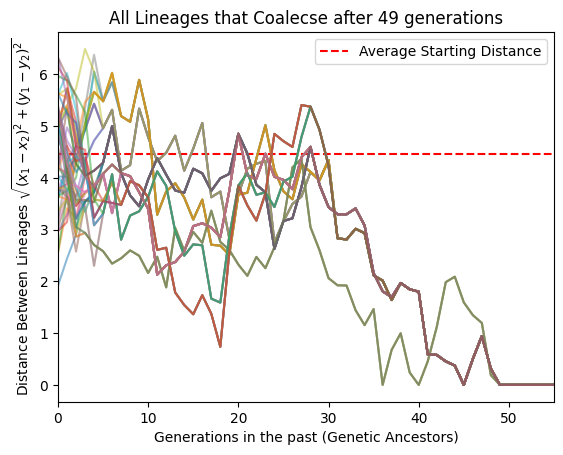

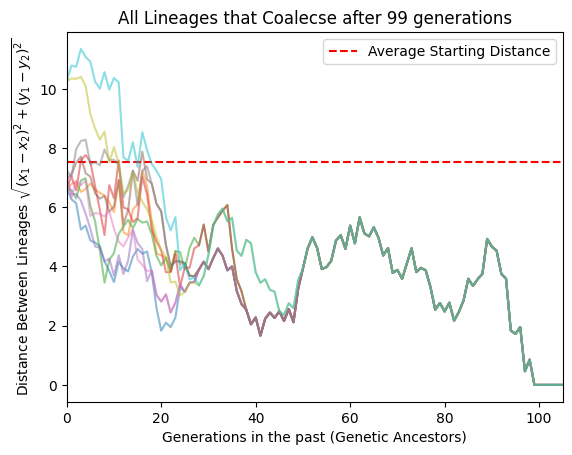

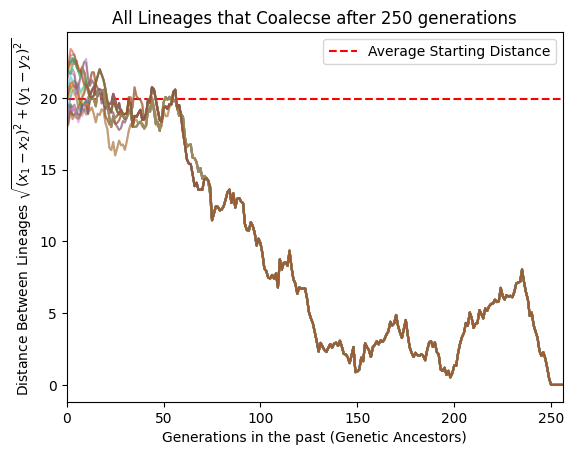

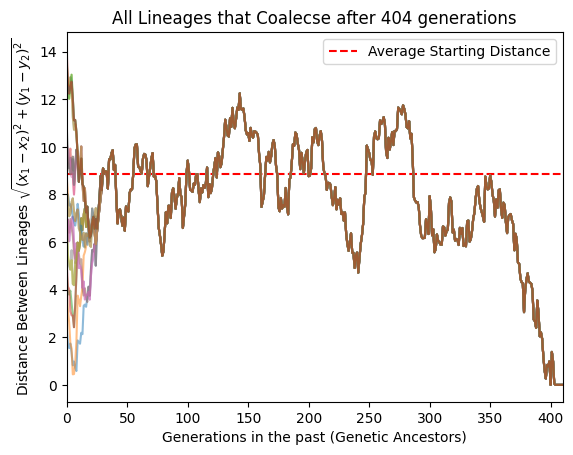

In [338]:
t = [5, 10, 50, 100, 251, 405]
for i in t:
    graph_d4ct(ct, at, locations, i)

In [340]:
a = np.unique(ct, return_counts=True)
np.intersect1d(np.where(a[1] > 100), np.where(a[0]<500))
good = [a[0][i] for i in np.delete(np.intersect1d(np.where(a[1] > 100), np.where(a[0]<500)), 0)]

In [407]:
a[1][148]

240

In [342]:
np.shape(good)[0]

87

In [360]:
# Analyze Some Data
good_data = np.zeros((np.shape(good)[0], 7))
for i in np.arange((np.shape(good)[0])):
    goc = good[i]
    data = data4ct(ct, at, locations, goc)
    good_data[i][0] = np.mean(data[:,0])
    good_data[i][1] = np.mean(data[:,1])
    good_data[i][2] = np.mean(data[:,5])
    good_data[i][3] = np.mean(data[:,10])
    good_data[i][4] = np.mean(data[:,50])
    good_data[i][5] = np.mean(data[:,100])
    good_data[i][6] = np.mean(data[:,250])

In [353]:
good_data[2]

array([0.65092699, 0.26516652, 0.5429768 , 0.09632318, 0.        ,
       0.        , 0.        , 0.        ])

NameError: name 'good' is not defined

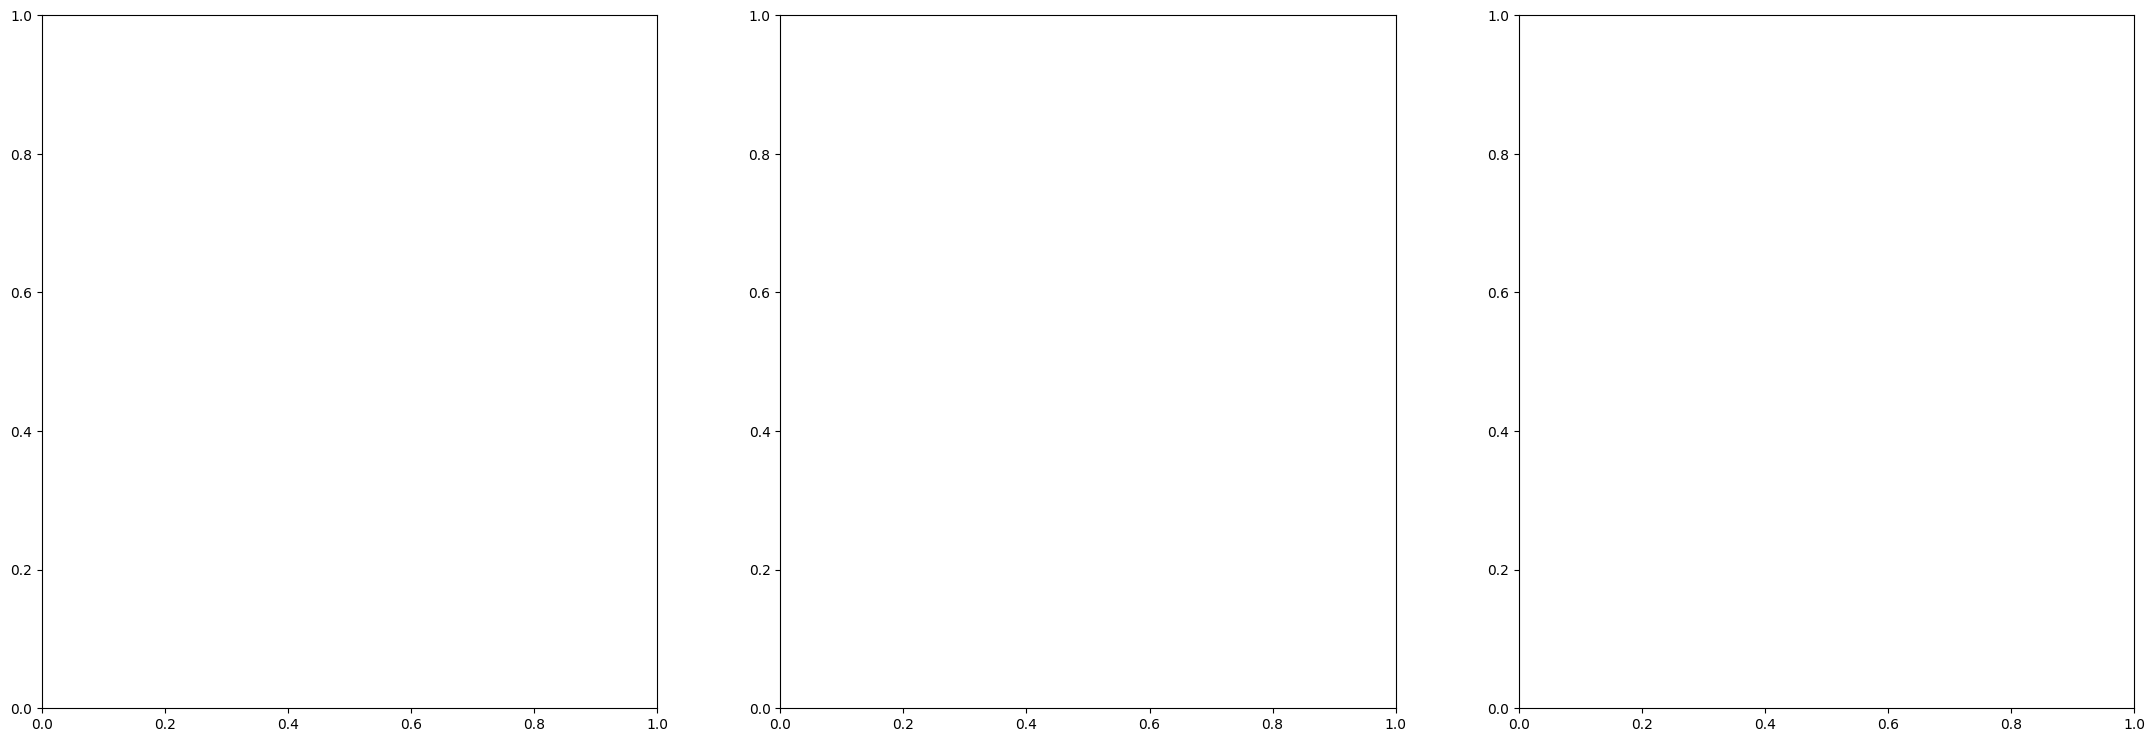

In [24]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(27, 9)

axs[0].plot(good, good_data[:,0], alpha=.5)
axs[0].plot(good, good_data[:,1], alpha=.5)
axs[0].set_xlabel("Coalescence of Two Lineages")
axs[0].set_ylabel("Mean Distance Between Lineages")
axs[0].grid(False)
axs[0].legend(["Present", "1 gen ago", "5 gen ago", "10 gen ago", "50 gen ago", "100 gen ago"])

axs[1].plot(good, good_data[:,1] - good_data[:,0], alpha=.5)
axs[1].axhline(y=0, color ='Red', linestyle = '--')
axs[1].set_xlabel("Coalescence of Lineages (Generations)")
axs[1].set_ylabel("Mean Distance Between Lineages")
axs[1].grid(False)
axs[1].legend(["Mean Ancestral Distance 1 Gen Ago - Present Distance"])

In [372]:
# Analyze Some More Data
heat_data = np.zeros((np.shape(good)[0], 3))
for i in np.arange((np.shape(good)[0])):
    goc = good[i]
    data = data4ct(ct, at, locations, goc)
    b1n=0
    b1d=0
    b2n=0
    b2d=0
    b3n=0
    b3d=0
    for j in np.arange(np.shape(data)[0]):
        if data[j][0] < 5:
            b1d = b1d + 1
            if data[j][0] < data[j][1]: b1n = b1n + 1
        elif data[j][0] < 15:
            b2d = b2d + 1
            if data[j][0] < data[j][1]: b2n = b2n + 1
        else:
            b3d = b3d + 1
            if data[j][0] < data[j][1]: b3n = b3n + 1
    if (b1d > 0): heat_data[i][0] = b1n / b1d
    if (b2d > 0): heat_data[i][1] = b2n / b2d
    if (b3d > 0): heat_data[i][2] = b3n / b3d

In [92]:
slim_ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,1,0,0,"{'slim_id': 176573660, 'is_null': Fal..."
1,1,1,0,0,"{'slim_id': 176573661, 'is_null': Fal..."
2,1,1,1,0,"{'slim_id': 176573662, 'is_null': Fal..."
3,1,1,1,0,"{'slim_id': 176573663, 'is_null': Fal..."
4,1,1,2,0,"{'slim_id': 176573664, 'is_null': Fal..."
5,1,1,2,0,"{'slim_id': 176573665, 'is_null': Fal..."
6,1,1,3,0,"{'slim_id': 176573666, 'is_null': Fal..."
7,1,1,3,0,"{'slim_id': 176573667, 'is_null': Fal..."
8,1,1,4,0,"{'slim_id': 176573668, 'is_null': Fal..."
9,1,1,4,0,"{'slim_id': 176573669, 'is_null': Fal..."


In [91]:
slim_ts.tables.individuals

id,flags,location,parents,metadata
0,327680,"45.871732695099084, 20.91526835109697, 0.0","210552, 211182","{'pedigree_id': 88286830, 'pedigree_p..."
1,327680,"46.29562589577473, 20.410295959320763, 0.0","210552, 211182","{'pedigree_id': 88286831, 'pedigree_p..."
2,327680,"28.305890139822342, 25.954432328723577, 0.0","211076, 210367","{'pedigree_id': 88286832, 'pedigree_p..."
3,327680,"27.82002794467209, 25.62403844975797, 0.0","211076, 210367","{'pedigree_id': 88286833, 'pedigree_p..."
4,327680,"38.82414470567467, 4.340822282192338, 0.0","208408, 211065","{'pedigree_id': 88286834, 'pedigree_p..."
5,327680,"26.988496056713533, 27.59963003620598, 0.0","211500, 209208","{'pedigree_id': 88286835, 'pedigree_p..."
6,327680,"27.55228798102651, 26.934329642768155, 0.0","211500, 209208","{'pedigree_id': 88286836, 'pedigree_p..."
7,327680,"34.93143392112511, 33.46740461755189, 0.0","211146, 210428","{'pedigree_id': 88286837, 'pedigree_p..."
8,327680,"34.96032611757085, 33.056803791442796, 0.0","211146, 210428","{'pedigree_id': 88286838, 'pedigree_p..."
9,327680,"48.08633427831148, 28.77358427880084, 0.0","211041, 211815","{'pedigree_id': 88286839, 'pedigree_p..."


In [120]:
data = get_nodes_above_sample(slim_ts, G1, 13)
[t[1] for t in data]

[9849,
 16675,
 19971,
 20503,
 24174,
 25271,
 28218,
 29358,
 30160,
 31620,
 32581,
 33624,
 35244,
 35881,
 37106,
 38102,
 38777,
 39502,
 40369,
 40844,
 41214,
 42368,
 43112,
 43595,
 44174,
 44439,
 44944,
 45588,
 46075,
 46930,
 47326,
 47528,
 48182,
 48588,
 48843,
 49502,
 50035,
 50103,
 50566,
 51175,
 51315,
 51847,
 52305,
 52381,
 52932,
 53156,
 53515,
 53836,
 54222,
 54670,
 55007,
 55260,
 55583,
 55769,
 55959,
 56243,
 56734,
 56908,
 57106,
 57588,
 57838,
 57973,
 58287,
 58478,
 58627,
 59054,
 59362,
 59587,
 59700,
 59951,
 60154,
 60373,
 60570,
 60845,
 61006,
 61308,
 61605,
 61781,
 61882,
 62155,
 62277,
 62533,
 62680,
 62991,
 63038,
 63372,
 63530,
 63665,
 63830,
 64063,
 64208,
 64388,
 64557,
 64749,
 64855,
 64978,
 65201,
 65432,
 65558,
 65660,
 65891,
 66091,
 66180,
 66318,
 66562,
 66623,
 66810,
 67005,
 67192,
 67316,
 67537,
 67626,
 67799,
 67972,
 67996,
 68226,
 68378,
 68526,
 68645,
 68776,
 69011,
 69138,
 69278,
 69418,
 69559,
 

In [110]:
get_nodes_above_sample(ts1, G2, 13)

[(13, 169), (13, 193), (13, 194)]

In [66]:
slim_ts.node(8843)

Node(id=8843, flags=0, time=1.0, population=1, individual=65204, metadata={'slim_id': 1763902, 'is_null': False, 'genome_type': 0})

In [50]:
slim_ts.individual(0)

Individual(id=0, flags=327680, location=array([10.51055227, 11.38171315,  0.        ]), parents=array([68101, 66072], dtype=int32), nodes=array([0, 1], dtype=int32), metadata={'pedigree_id': 886339, 'pedigree_p1': 885535, 'pedigree_p2': 883011, 'age': 0, 'subpopulation': 1, 'sex': -1, 'flags': 0})

In [48]:
slim_ts.node(8906)

Node(id=8906, flags=0, time=1.0, population=1, individual=65247, metadata={'slim_id': 1764013, 'is_null': False, 'genome_type': 0})